In [1]:
from neuron import h, load_mechanisms
from netpyne import specs, sim
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
h.load_file("stdrun.hoc")

cwd = os.getcwd()
mod_dir = '/Users/katedoxey/Desktop/research/projects/tinnitus model/code/DCN_model/mod'
load_mechanisms(mod_dir)

True

In [3]:
cell_types = ['P', 'I2']  #['P', 'I2', 'W', 'AN']
record_cells = [(f'{cell_type}_pop', 0) for cell_type in cell_types]

dt = 0.001

cfg = specs.SimConfig()	
cfg.duration = 1200				                 
cfg.dt = dt								                # Internal integration timestep to use
cfg.verbose = True							                # Show detailed messages
cfg.recordCells = ['all']
cfg.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}}
cfg.recordStep = dt
# cfg.recordStim = True
# cfg.filename = os.path.join(sim_dir, f'{sim_label}-DCN') 	# Set file output name
cfg.savePickle = False
# cfg.analysis['plotTraces'] = {'include': ['all'], 'saveFig': False, 'showFig': False}  # Plot recorded traces for this list of cells
# cfg.analysis['recordTraces'] = 
# cfg.analysis['plotSpikeFreq'] = {'include': ['all'], 'saveFig': True, 'showFig': True}
cfg.hParams['celsius'] = 34.0 
cfg.hParams['v_init'] = -60

In [4]:
netParams = specs.NetParams()

IzhCell = {'secs': {}}
IzhCell['secs']['soma'] = {'geom': {}, 'pointps': {}}                        # soma params dict
IzhCell['secs']['soma']['geom'] = {'diam': 50, 'L': 50, 'cm': 1}    # soma geometry, cm = 31.831
IzhCell['secs']['soma']['pointps']['Izhi'] = {                               # soma Izhikevich properties
    'mod':'Izhi2007b',
    'C':1,
    'k': 0.7,
    'vr':-60,
    'vt':-40,
    'vpeak':35,
    'a':0.03,
    'b':-2,
    'c':-50,
    'd':100,
    'celltype':1}
# IzhCell['secs']['soma']['threshold'] = -20
netParams.cellParams['IzhCell'] = IzhCell 


In [5]:
n_cells = 1

pop_labels_nums = {cell_type: n_cells for cell_type in cell_types}

for pop_label, pop_num in pop_labels_nums.items():
    netParams.popParams[f'{pop_label}_pop'] = {'cellType': 'IzhCell',
                                                'numCells': pop_num}

In [7]:
stim_delay = 100
stim_dur = 1000

nsa_freq = 80

syn_weight = 0.2

netParams.popParams[f'vecstim_NSA'] = {
            'cellModel': 'VecStim',
            'numCells': 1,  # int(len(syn_secs)/4),
            'spikePattern': {'type': 'poisson',
                            'start': stim_delay,
                            'stop': stim_dur+stim_delay,
                            'frequency': nsa_freq}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
        }

netParams.connParams[f'vecstim_NSA->P'] = {
    'preConds': {'pop': f'vecstim_NSA'},
    'postConds': {'pop': 'P_pop'},
    'sec': 'soma',
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': syn_weight,  # 
    # 'synMechWeightFactor': [0.5,0.5],
    'delay': 'defaultDelay + dist_2D/propVelocity',
    'connList': [[0,0]]
    }

In [8]:

netParams.popParams[f'vecstim_ANF'] = {
    'cellModel': 'VecStim',
    'numCells': 1,  # int(len(syn_secs)/4),
    'spikePattern': {'type': 'poisson',
                    'start': stim_delay,
                    'stop': stim_dur+stim_delay,
                    'frequency': np.random.uniform(20,40)}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
}

netParams.connParams[f'vecstim_ANF->ALL'] = {
    'preConds': {'pop': f'vecstim_ANF'},
    'postConds': {'pop': [f'{cell_type}_pop' for cell_type in cell_types]},
    'sec': 'soma',
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': syn_weight,  # 
    # 'synMechWeightFactor': [0.5,0.5],
    'delay': 'defaultDelay + dist_2D/propVelocity',
    'connList': [[0,i] for i in range(len(cell_types))]
}

In [9]:
# TODO: add inhibitory connections - without (start) and with W-cells
# TODO: input - best frequency (low, med, high, med, low)

In [26]:
import matplotlib.gridspec as gridspec

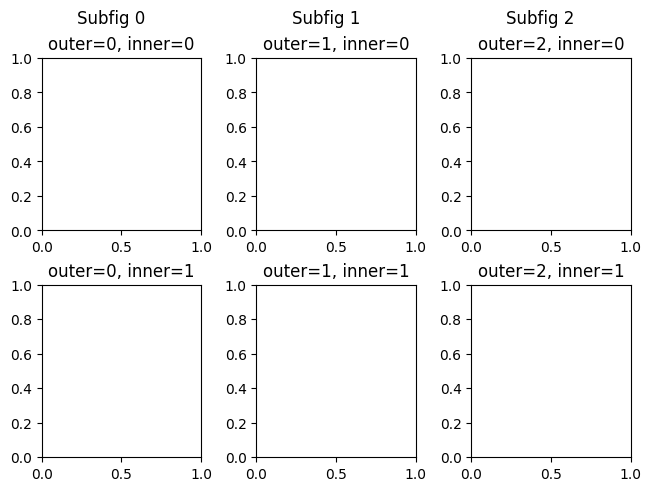

In [43]:
fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(1, len(i_weights))

for outer_i, subfig in enumerate(subfigs.flat):

    subfig.suptitle(f'Subfig {outer_i}')
    axs = subfig.subplots(2,1)

    for inner_i, ax in enumerate(axs.flat):
        ax.set_title(f'outer={outer_i}, inner={inner_i}')

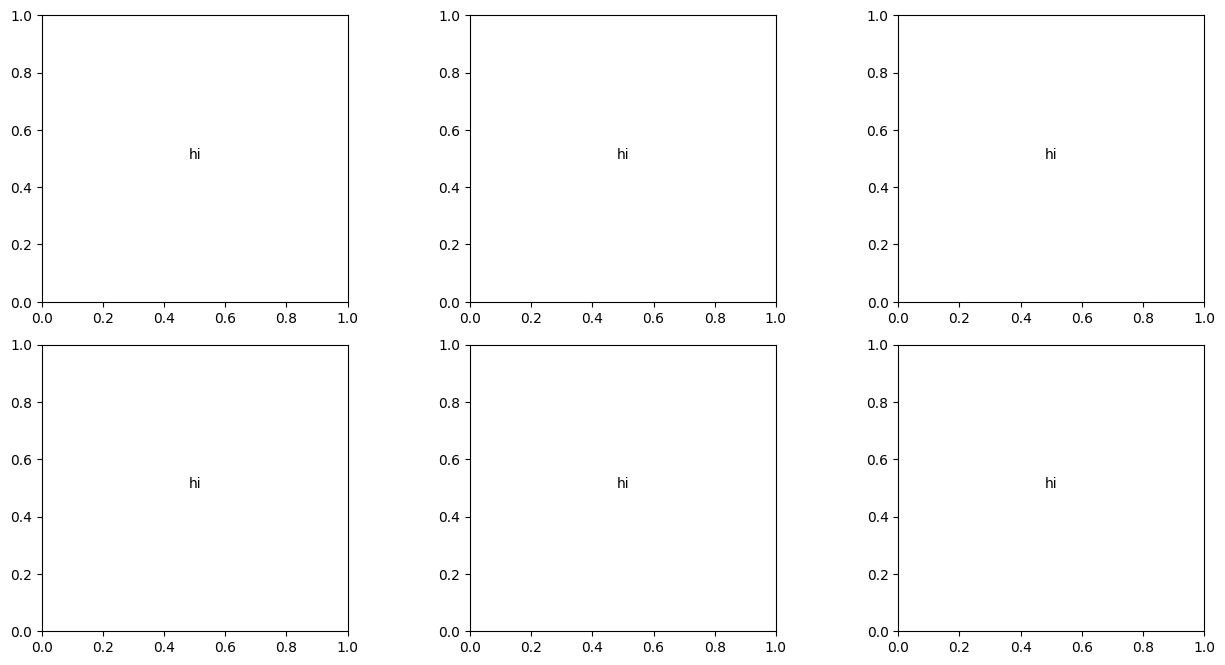

In [41]:
fig = plt.figure(figsize=(15, 8))
outer = gridspec.GridSpec(1, len(i_weights), wspace=0.4, hspace=0.4)

for j in range(len(i_weights)):

    inner = gridspec.GridSpecFromSubplotSpec(len(cell_types), 1, subplot_spec=outer[j], wspace=0.25, hspace=0.15)

    for k in range(len(cell_types)):
        ax = plt.Subplot(fig, inner[k])
        t = ax.text(0.5, 0.5, 'hi')
        t.set_ha('center')

        fig.add_subplot(ax)

fig.tight_layout()


Start time:  2025-02-03 21:50:46.182183

Creating network of 4 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop P_pop, on node 0, 
Instantiated 1 cells of population P_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=1) of pop I2_pop, on node 0, 
Instantiated 1 cells of population I2_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
    Error while setting 'spikePattern' param to VecStim[172]
Cell 0/0 (gid=2) of pop vecstim_NSA, on node 0, 
Instantiated 1 cells of population vecstim_NSA
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
    Error while setting 'spikePattern' param to VecStim[173]
Cell 0/0 (gid=3) of pop vecstim_ANF, on node 0, 
Instantiated 1 cells of population vecstim_ANF
  Number of cells on node 0: 4 
  Done; cell creation time = 0.00 s.
Making connections...
Generating set of connections from list (rule: vecstim_NSA->P) ...
  Creat

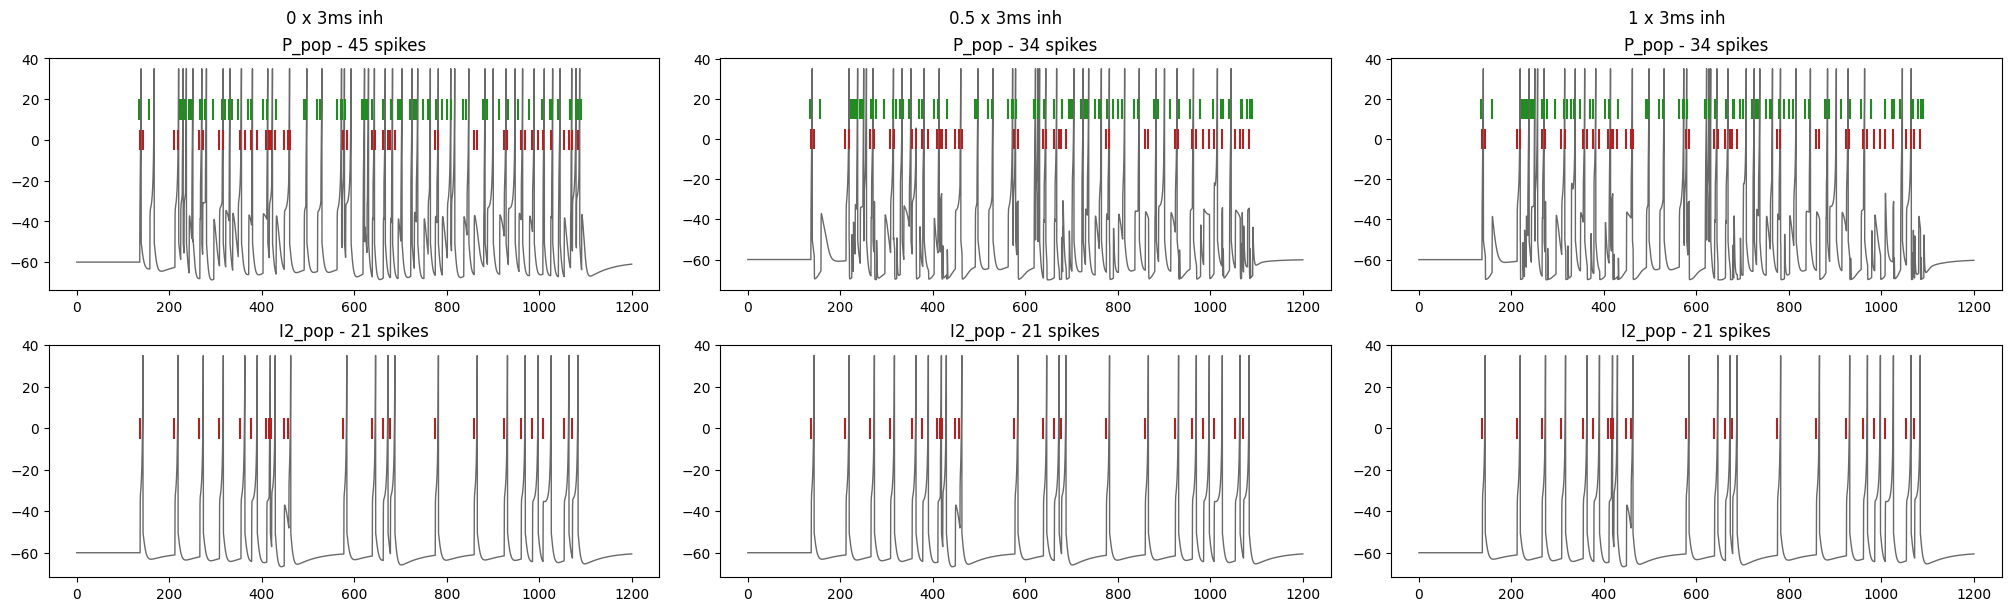

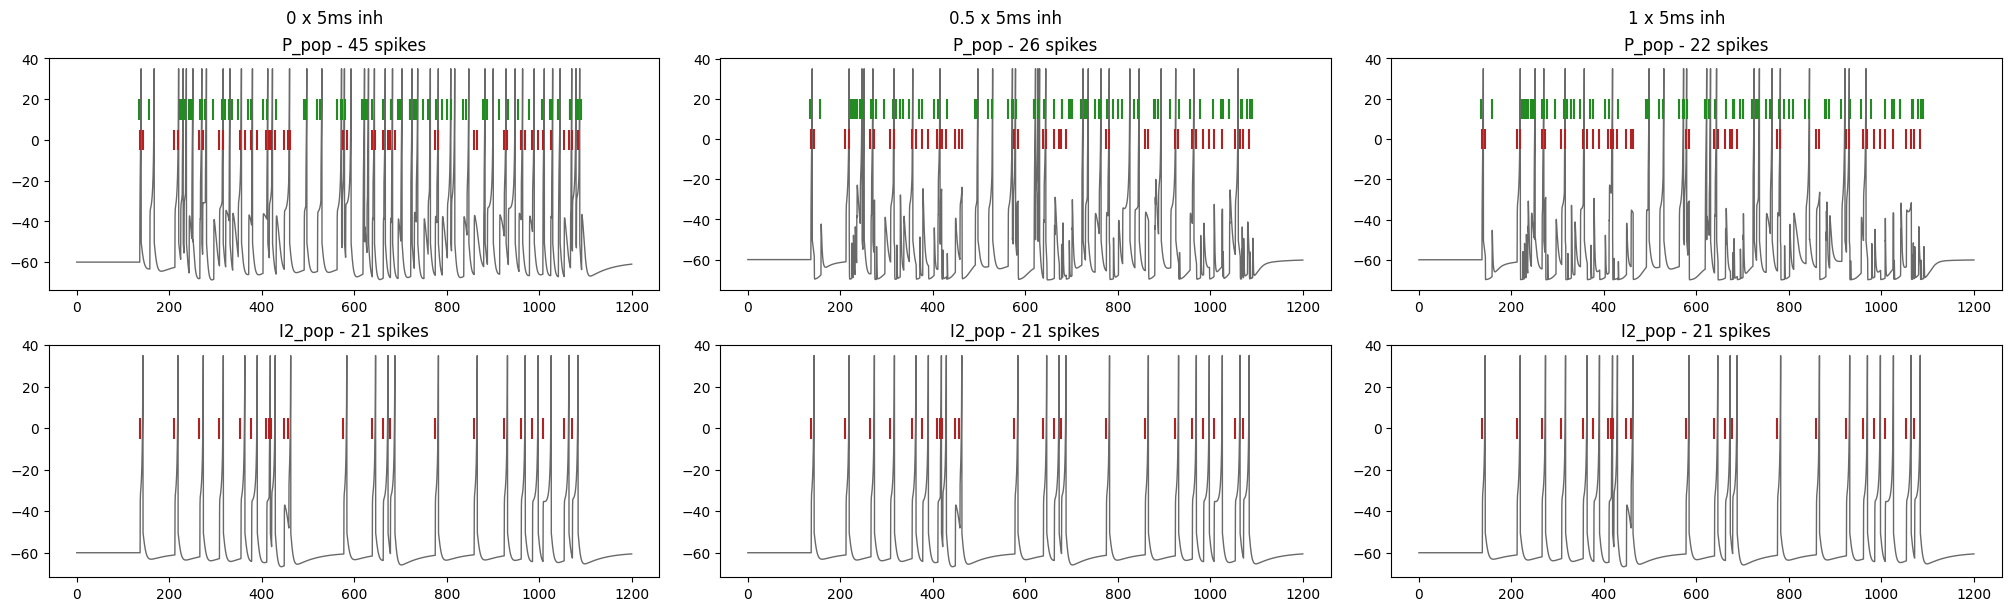

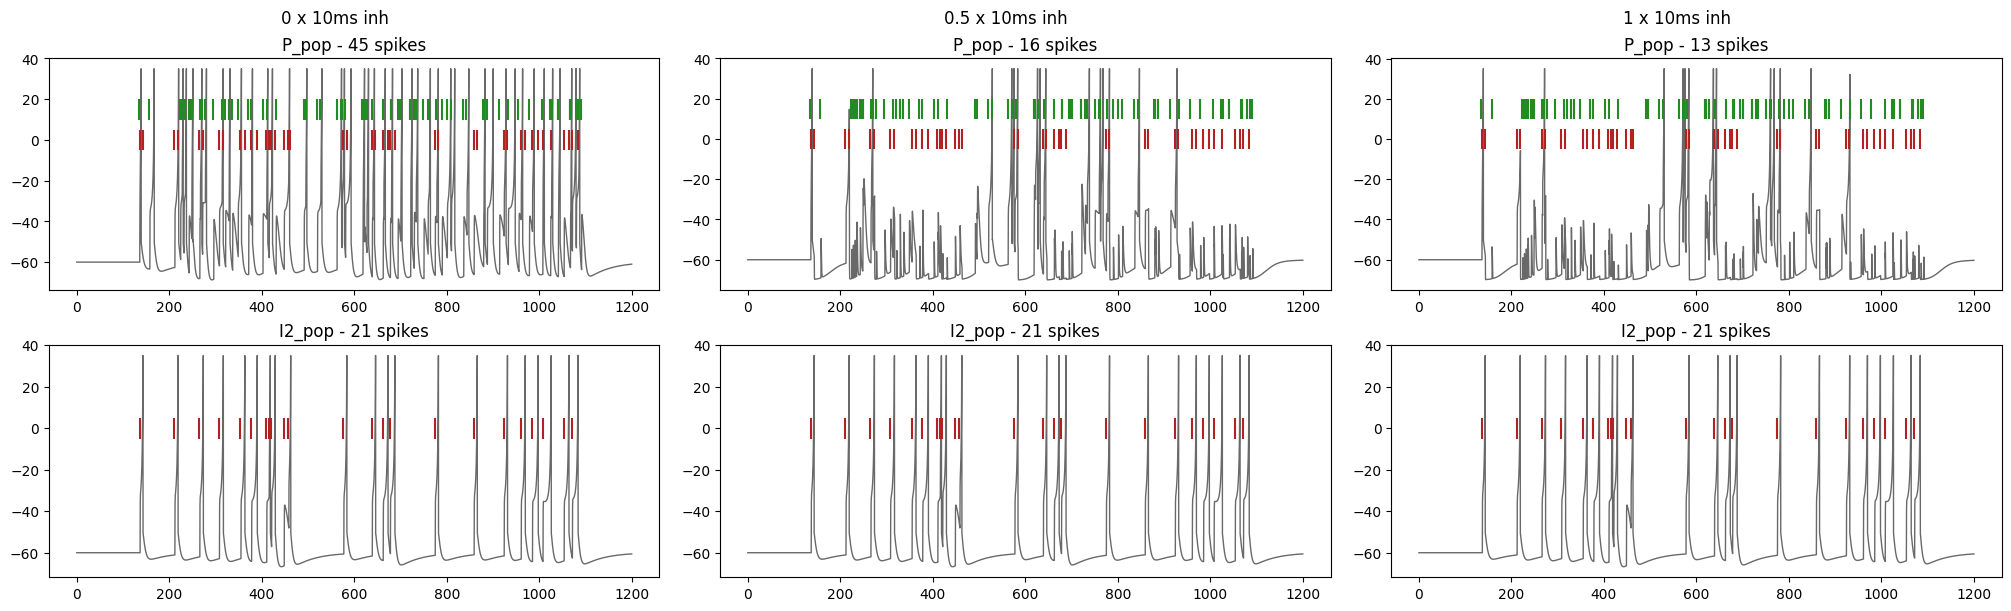

In [53]:
temp = 5


i_weights = [0, 0.5, 1]
i_taus = [3, 5, 10]

for i_tau in i_taus:

    fig = plt.figure(figsize=(20, 6), constrained_layout=True)
    
    subfigs = fig.subfigures(1, len(i_weights))
    subfigs = subfigs.flat

    for outer_i, i_weight in enumerate(i_weights):

        subfig = subfigs[outer_i]
        subfig.suptitle(f'{i_weight} x {i_tau}ms inh')
        axs = subfig.subplots(len(cell_types), 1)
        axs = axs.flat

        e_tau = 0.2
        # i_tau = 2
        netParams.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': e_tau, 'e': 10}
        netParams.synMechParams['inh'] = {'mod': 'ExpSyn', 'tau': i_tau, 'e': -70}

        netParams.connParams['I2->P'] = {
            'preConds': {'pop': 'I2_pop'},
            'postConds': {'pop': 'P_pop'},
            'synsPerConn': 1,
            'synMech': 'inh',
            'weight': i_weight,
            'probability': 1.0
            # 'connList': [[0,0]]
        }

        (pops, cells, conns, stims, simData) = sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg, output=True)

        t = np.array(simData['t'])
        spkid = np.array(simData['spkid'])
        spkt = np.array(simData['spkt'])

        middle_cells = [i for i in range(n_cells//2 - 3, n_cells//2 + 3) ]
            
        base_colors = ['k', 'tab:green', 'tab:purple']

        for inner_i, (pop_label, pop_cells) in enumerate(pops.items()):

            cell_type = pop_label.split('_')[0]

            if 'vecstim' in cell_type:
                continue

            ax = axs[inner_i]

            for cell_i, cell_id in enumerate(pop_cells.cellGids):

                v_soma = list(simData['V_soma'][f'cell_{cell_id}'])

                ax.plot(t, v_soma, color='dimgrey', linewidth=1)
                # fig.add_subplot(ax)

                for conn in conns[cell_id]:
                    pregid = conn['preGid']

                    if 'NSA' in conn['label']:
                        color = 'forestgreen'
                        middle = 15
                    elif 'ANF' in conn['label']:
                        color = 'firebrick'
                        middle = 0
                    # elif 'inh' in conn['label']:
                    #     color= 'tab:blue'
                    #     middle = -15
                    
                    spike_train = spkt[np.where(spkid == pregid)]
                    ax.vlines(spike_train, ymin=middle-5, ymax=middle+5, color=color)

                spikes = spkt[np.where(spkid == cell_id)]
                ax.set_title(f'{pop_label} - {len(spikes)} spikes')

        # fig.suptitle(f'{i_weight} x {i_tau}ms inh')
        # fig.tight_layout()
